In [48]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

In [49]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16

In [50]:
print(os.listdir("image/classification"))
print(os.listdir("image/classification/train"))

['.DS_Store', 'train', 'validation']
['.DS_Store', 'chihuahua', 'muffin']


In [51]:

SIZE = 256  #Resize images

#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("image/classification/train/*"):
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
        # print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

chihuahua


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


muffin


In [52]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("image/classification/validation/*"):
    fruit_label = directory_path.split("/")[-1]
    print(fruit_label)
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

chihuahua
image/classification/validation/chihuahua/chihuahua_836.JPG
image/classification/validation/chihuahua/chihuahua_822.JPG
image/classification/validation/chihuahua/chihuahua_823.JPG
image/classification/validation/chihuahua/chihuahua_837.JPG
image/classification/validation/chihuahua/chihuahua_821.JPG
image/classification/validation/chihuahua/chihuahua_835.JPG
image/classification/validation/chihuahua/chihuahua_809.JPG
image/classification/validation/chihuahua/chihuahua_808.JPG
image/classification/validation/chihuahua/chihuahua_834.JPG
image/classification/validation/chihuahua/chihuahua_820.JPG
image/classification/validation/chihuahua/chihuahua_818.JPG
image/classification/validation/chihuahua/chihuahua_824.JPG
image/classification/validation/chihuahua/chihuahua_830.JPG
image/classification/validation/chihuahua/chihuahua_831.JPG
image/classification/validation/chihuahua/chihuahua_825.JPG
image/classification/validation/chihuahua/chihuahua_819.JPG
image/classification/validatio

In [53]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [54]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [55]:
###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0
#One hot encode y values for neural network. 
# from keras.utils import to_categorical
# y_train_one_hot = to_categorical(y_train)
# y_test_one_hot = to_categorical(y_test)

#############################

In [56]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

In [57]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [58]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)



40/40 [==============================] - 677s 17s/step


In [59]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF

In [60]:
#XGBOOST
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

5/5 [==============================] - 29s 5s/step


In [61]:
#Now predict using the trained RF model. 
prediction = model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(prediction)

In [62]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

Accuracy =  0.9733333333333334


<AxesSubplot:>

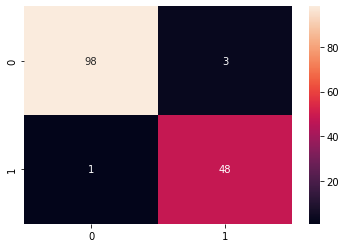

In [63]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, prediction)
#print(cm)
sns.heatmap(cm, annot=True)

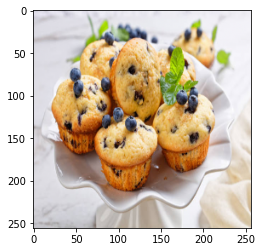

In [64]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)

In [65]:
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model.predict(input_img_features)[0] 
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

1/1 [==============================] - 0s 177ms/step
The prediction for this image is:  ['muffin']
The actual label for this image is:  muffin
